## 0. Introduction 

The aim of this lab is to get familiar with **classification problems** and **logistic regression**. We will be using some code extracts that were implemented last week and build a logistic regression model. 

1.   This lab is part of Assignment 1 part 2.
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebooks.
3. A single pdf report should be submitted on QMplus along with the completed Notebooks **for both** this and the Neural Networks notebook (lab 6).
4. The deadline for **both** is **Friday, 18 November 11:59pm**
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!). 


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [3529]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
from sklearn.metrics import classification_report
import typing
%matplotlib inline

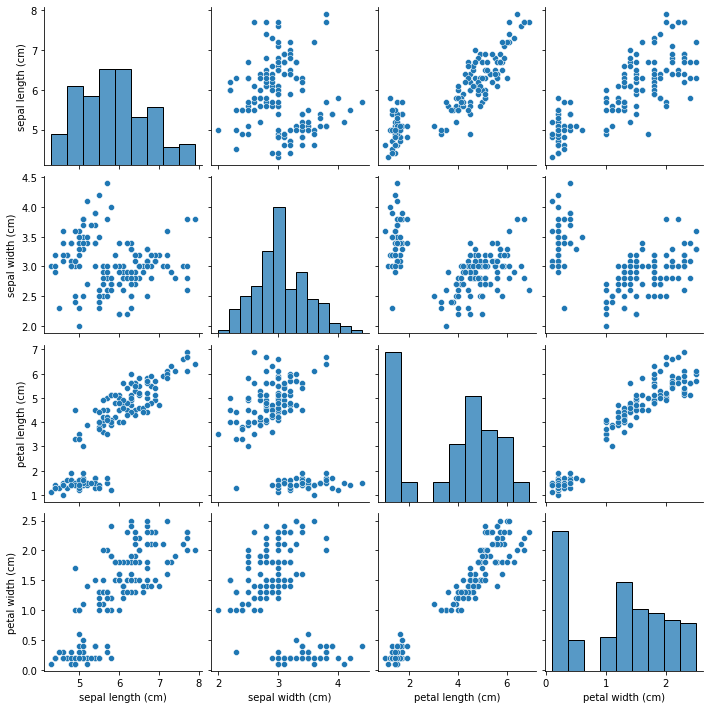

In [3530]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)


In [3531]:
iris_db.data


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [3532]:
iris_db.data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [3533]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)


<font color="maroon">**Q1.** We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font>

In [3534]:
### your code here

def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
    # Adding a small Offset to the denominator to prevent divide by zero exception
    offset = 1e-6
    x_std_features = (x - mu) / (sigma + offset)
    return x_std_features
# your code here
x_train_dimensions = list(range(x_train.dim() - 1))
x_train_mean = torch.mean(x_train, dim=x_train_dimensions)
x_train_std = torch.std(x_train, dim=x_train_dimensions)
x_train_norm = norm_set(x_train, x_train_mean, x_train_std)


x_test_dimensions = list(range(x_test.dim() - 1))

x_test_mean = torch.mean(x_test, dim=x_test_dimensions)
x_test_std = torch.std(x_test, dim=x_test_dimensions)
x_test_norm = norm_set(x_test, x_test_mean, x_test_std)

plot_x_train_norm = pd.DataFrame(x_train_norm.numpy())
plot_x_train = pd.DataFrame(X_train)
print("\n")
print("Un-Normalised Values")
print(plot_x_train.head(10))
print("\n")
print("Normalised Values")
print(plot_x_train_norm.head())
#Initialising the normalised values to xtrain and xtest
x_train = x_train_norm
x_test = x_test_norm




Un-Normalised Values
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
22                 4.6               3.6                1.0               0.2
15                 5.7               4.4                1.5               0.4
65                 6.7               3.1                4.4               1.4
11                 4.8               3.4                1.6               0.2
42                 4.4               3.2                1.3               0.2
146                6.3               2.5                5.0               1.9
51                 6.4               3.2                4.5               1.5
27                 5.2               3.5                1.5               0.2
4                  5.0               3.6                1.4               0.2
32                 5.2               4.1                1.5               0.1


Normalised Values
          0         1         2         3
0 -1.467781  1.198629 -1.556010 -1.307120
1 -0.132515  2.

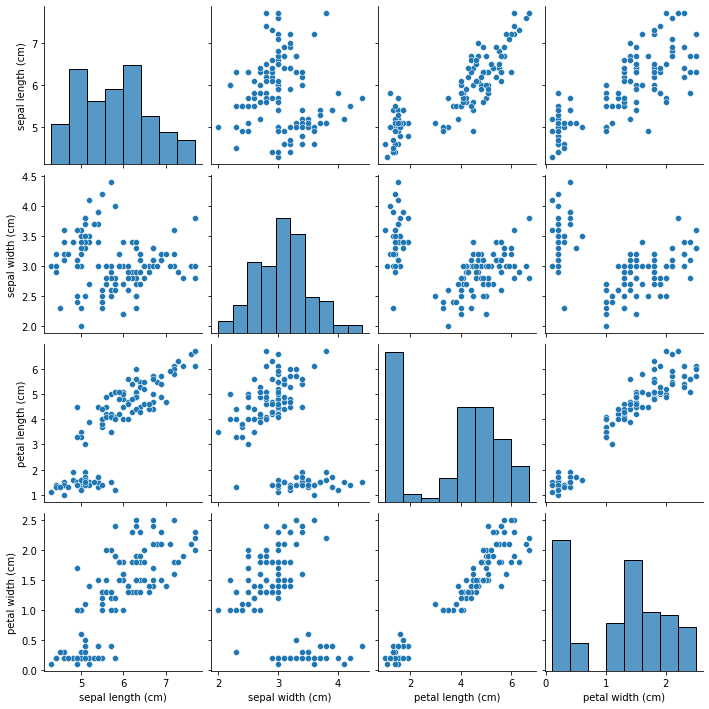

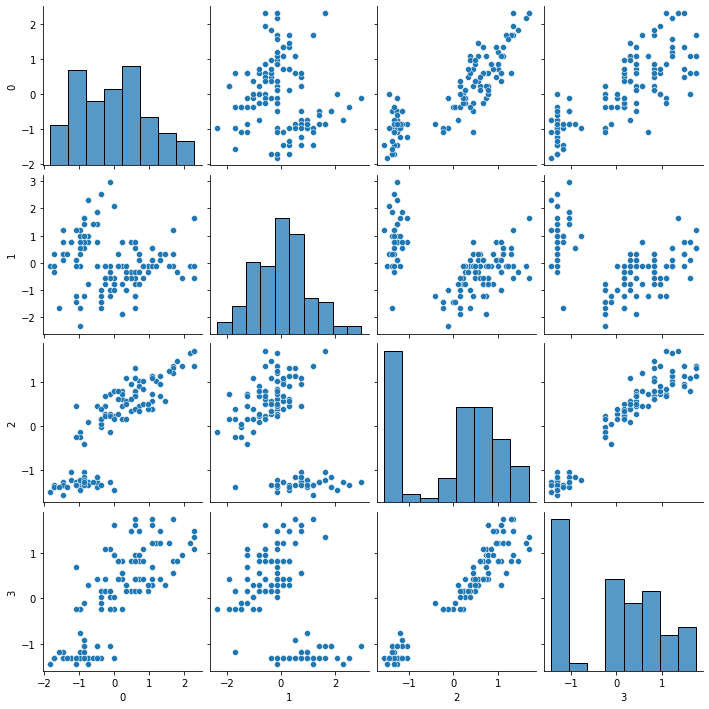

In [3535]:
sn.pairplot(plot_x_train)
sn.pairplot(plot_x_train_norm)

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

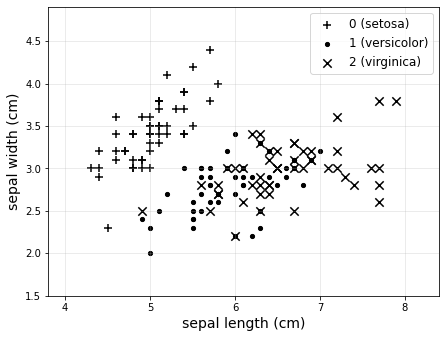

sepal length (cm)
sepal width (cm)
petal length (cm)
['setosa' 'versicolor' 'virginica']


In [3536]:
X = iris_db.data.iloc[:, :2] 
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0], 
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l], 
      s=70, 
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()
print(iris_db.feature_names[0])
print(iris_db.feature_names[1])
print(iris_db.feature_names[2])
print(iris_db.target_names)

Is the data linearly separable?

In [3537]:
## By looking at the above plot we can see that setosa is well separated from versicolor based on the sepal length and speal width

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [3538]:
train_set_1 = x_train[:, :2]
test_set_1 = x_test[:, :2]
#print(x_train)

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()


## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

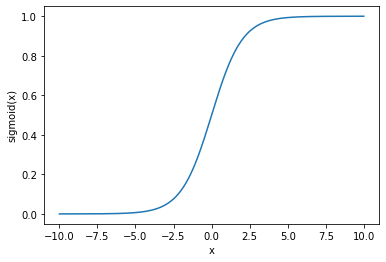

In [3539]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    output_value = 0.0
    #m = nn.Sigmoid()
    #output_value = m(z)
    #output_value = torch.sigmoid(z)
    output_value = 1./(1. + torch.exp(-z))
    
  ### your code here
    return output_value


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [3540]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = 0
    ### your code here
    y = sigmoid(torch.matmul(x, torch.transpose(self.weight, 0, 1)))
    return y

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} 
$

**Q4.** Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

In [3541]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  ### your code here
  total_bce_loss = torch.sum(torch.mul(-y_true , torch.log(y_pred)) - torch.mul((1-y_true), torch.log(1 - y_pred)))
  num_of_samples = y_pred.shape[0]
  mean_bce_loss = total_bce_loss / num_of_samples
  return mean_bce_loss
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  ###
  prediction = model(X)
  weight -= lr * sum(torch.mul((prediction-y),X))
  model.weight = nn.Parameter(weight, requires_grad=False)

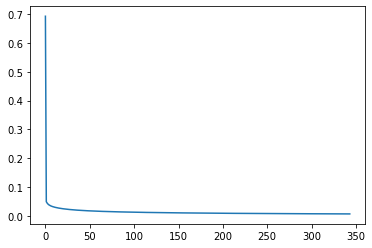

Parameter containing:
tensor([[-15.2395,   7.4105,  -9.6464]])
Minimum cost: 0.006302221212536097


In [3542]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost.detach().numpy())
    gradient_descent_step(model, x, y, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
print("Model", model)
alpha = 0.1 # select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

<font color="maroon"> **Q5.** Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font>

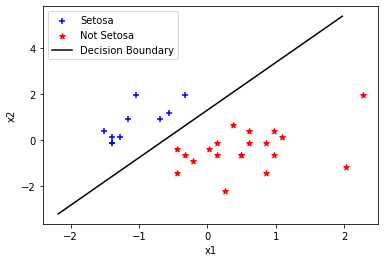

In [3543]:
### your code here
def plot_scatter_data(X, y, ax1):

    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    
    index_zero = torch.where(y==0)
    index_one = torch.where(y==1)
  
    ax1.scatter(X[index_one[0], 0], X[index_one[0], 1], c='blue', marker='+', label='Setosa')
    ax1.scatter(X[index_zero[0], 0], X[index_zero[0], 1], c='red', marker='*', label='Not Setosa')
    
    return ax1

def plot_decision_boundary(X, weights, ax1):
    min_x1 = 0.0
    max_x1 = 0.0
    x2_on_min_x1 = 0.0
    x2_on_max_x1 = 0.0

    min_x1 = torch.amin(X,0)[1]
    max_x1 = torch.amax(X,0)[1]


    x2_on_min_x1 = - (weights[0,0] * min_x1 + weights[0,2]) / weights[0,1]
    x2_on_max_x1 = - (weights[0,0] * max_x1 + weights[0,2]) / weights[0,1]

    x_array = [min_x1, max_x1]
    y_array = [x2_on_min_x1, x2_on_max_x1]
    ax1.plot(x_array, y_array, c='black', label='Decision Boundary')

    ax1.legend()

fig1, ax1 = plt.subplots()
weights = model.weight
plot_scatter_data(x_test, setosa_test, ax1)

plot_decision_boundary(test_set_1, weights, ax1)

## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer. 

In [3544]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test)
print(y_train.shape)

tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0]])
torch.Size([120, 3])


In this section we will use the built in pytorch methods.


In [3545]:
alpha = 0.1
print(x_train.shape[1])
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


4


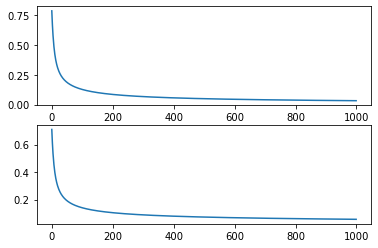

Minimum train cost: 0.03234468773007393
Minimum test cost: 0.05581975355744362


In [3546]:
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, optimiser, alpha)

How does the cost of the 4 attribute model compare to the previous one?

**Q6** Now train classifiers for the other two classes.[1 mark]

4
4


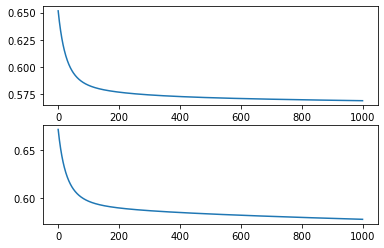

Minimum train cost: 0.5691567063331604
Minimum test cost: 0.5778191685676575


In [3547]:
### your code here
print(x_train.shape[1])
alpha = 0.1
print(x_train.shape[1])
versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
versicolor_optimiser = optim.SGD(versicolor_model.parameters(), alpha)
#print(y_train)
#print(versicolor_labels)
train(versicolor_model, x_train, versicolor_labels, x_test, versicolor_testy, versicolor_optimiser, alpha)
versicolor_pred = versicolor_model(x_test)

4
4


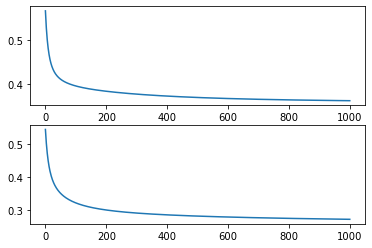

Minimum train cost: 0.36126306653022766
Minimum test cost: 0.2713172733783722


In [3548]:
### your code here
print(x_train.shape[1])
alpha = 0.1
print(x_train.shape[1])
virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
virginica_optimiser = optim.SGD(virginica_model.parameters(), alpha)
#print(y_train)
#print(versicolor_labels)
train(virginica_model, x_train, virginica_labels, x_test, virginica_testy, virginica_optimiser, alpha)
virginica_pred = virginica_model(x_test)
setosa_pred = setosa_model(x_test)

<font color="maroon"> **Q6.** Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font>

(0.0, 1.0, 0.0, 1.0)

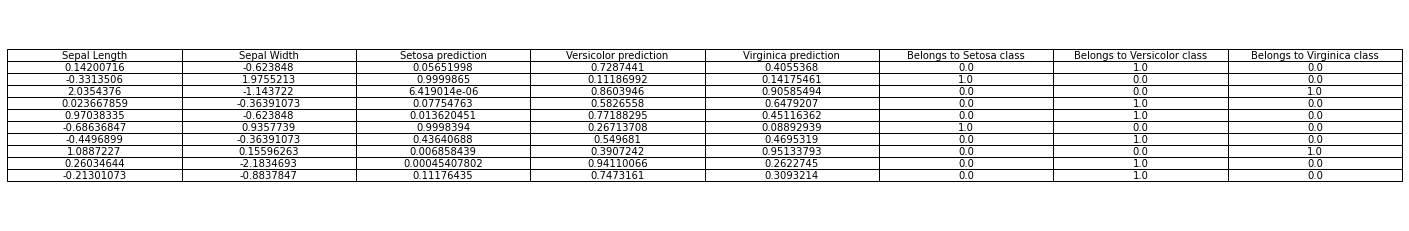

In [3549]:
### your code here
#torch.from_numpy(X_train.values).float()
plt.figure(figsize = (25, 4))
ypred = list()
for values in y_test:
    if values[0] == 1:
        ypred.append("Setosa")
    elif values[1] == 1:
        ypred.append("Versicolor")
    elif values[2] == 1:
        ypred.append("Virginica")
        
columns = ['Sepal Length', 'Sepal Width','Setosa prediction', 'Versicolor prediction', 'Virginica prediction', 'Belongs to Setosa class', 'Belongs to Versicolor class', 'Belongs to Virginica class']

table_data = torch.cat([x_test[:, :2], setosa_pred, versicolor_pred, virginica_pred, y_test], dim = 1).data[:10].detach().numpy()
table = plt.table(cellText = table_data, colLabels = columns, loc = 'center', cellLoc = 'center', rowLoc = 'center')
plt.axis('off')

<font color="maroon"> **Q7.** Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font>


In [3550]:
prediction_total = torch.concat([setosa_pred, versicolor_pred, virginica_pred], dim = 1)
softmax= nn.Softmax(dim=1)
softmax_output = softmax(prediction_total)
y_pred = softmax_output.argmax(dim = 1)
y_true = y_test.argmax(dim = 1)
correct_labels=y_true == y_pred
no_of_predictions = float(y_pred.size(0))
print("No of predictions: ", no_of_predictions)
print("No Of lables predicted correctly: ", correct_labels.sum().float())
accuracy = (correct_labels.sum().float()/ no_of_predictions ) * 100
print("Accuracy: ", accuracy)

No of predictions:  30.0
No Of lables predicted correctly:  tensor(27.)
Accuracy:  tensor(90.)


## 3. The XOR problem

<font color="maroon"> **Q8.** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? [2 marks] </font>

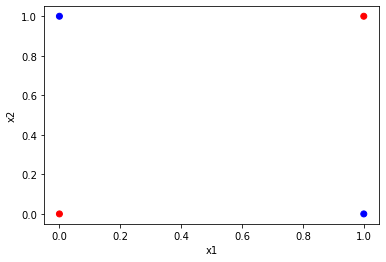

In [3551]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()